In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.ticker as mtick

In [7]:
base_path = os.path.join(os.getcwd(), '..', 'steam-insights-main')

games_df_path = os.path.join(base_path, 'games.csv')
genres_path = os.path.join(base_path, 'genres.csv')
steamspy_insights_path = os.path.join(base_path, 'steamspy_insights.csv')
tags_path = os.path.join(base_path, 'tags.csv')
reviews_path = os.path.join(base_path, 'reviews.csv')

In [8]:
# Read games.csv (only app_id and name) and drop rows with missing name
games = pd.read_csv(
    games_df_path,
    usecols=["app_id", "name", "release_date"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip'
)
games = games.dropna(subset=['name'])


# Price and appID from steamspy
steamspy = pd.read_csv(
    steamspy_insights_path,
    usecols=["app_id", "price"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
# Immediately drop rows with missing values in 'price'
steamspy = steamspy.dropna(subset=['price'])
# Replace 'N' in the 'price' column with NaN
steamspy['price'] = steamspy['price'].replace('N', np.nan)
# Convert price to numeric and handle any invalid entries as NaN
steamspy['price'] = pd.to_numeric(steamspy['price'], errors='coerce')
# Drop rows with NaN in 'price' after conversion
steamspy = steamspy.dropna(subset=['price'])
# Adjust price (divide by 100 to get price in euros)
steamspy['price'] = steamspy['price'] / 100



# Read tags.csv (only app_id and tag) and drop rows with missing tag - might need to group by appID to collect all tags together
tags_df = pd.read_csv(
    tags_path,
    usecols=["app_id", "tag"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
tags_df = tags_df.dropna(subset=['tag'])


# Read genres.csv (only app_id and genre) and drop rows with missing genre
genres_df = pd.read_csv(
    genres_path,
    usecols=["app_id", "genre"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
genres_df = genres_df.dropna(subset=['genre'])
# Group tags by app_id, joining multiple tags into one string
tags = tags_df.groupby("app_id")["tag"].apply(lambda x: ", ".join(x.astype(str))).reset_index()
# Group genres by app_id, joining multiple genres into one string
genres = genres_df.groupby("app_id")["genre"].apply(lambda x: ", ".join(x.astype(str))).reset_index()



# Read reviews.csv and drop rows with missing genre
reviews = pd.read_csv(
    reviews_path,
    usecols=["app_id", "review_score", "positive", "negative", "total"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
reviews['review_score'] = pd.to_numeric(reviews['review_score'].replace('N', 0), errors='coerce').fillna(0)
reviews = reviews.dropna(subset=['review_score', 'positive', 'negative', 'total'])


# Shows the number of rows in each data set
print("games:", len(games.axes[0]), "rows and", len(games.axes[1]), "columns")
print("steamspy:", len(steamspy.axes[0]), "rows and", len(steamspy.axes[1]), "columns")
print("tags:", len(tags.axes[0]), "rows and", len(tags.axes[1]), "columns")
print("genres:", len(genres.axes[0]), "rows and", len(genres.axes[1]), "columns")
print("reviews:", len(reviews.axes[0]), "rows and", len(reviews.axes[1]), "columns")

games: 140082 rows and 3 columns
steamspy: 90890 rows and 2 columns
tags: 117505 rows and 2 columns
genres: 122458 rows and 2 columns
reviews: 140082 rows and 5 columns


In [9]:
print(len(tags_df['tag'].unique()))
print(len(genres_df['genre'].unique()))

447
121


In [10]:
# Shows the tags are grouped for each game now
display(tags.head(10))
display(genres.head(10))

,app_id,tag
0,10,"1980s, 1990's, Action, Assassin, Classic, Comp..."
1,20,"1990's, Action, Class-Based, Classic, Co-op, C..."
2,30,"Action, Class-Based, Classic, Co-op, Difficult..."
3,40,"1990's, Action, Arena Shooter, Classic, Co-op,..."
4,50,"1990's, Action, Adventure, Aliens, Atmospheric..."
5,60,"3D, Action, Classic, Competitive, Conspiracy, ..."
6,70,"1990's, Action, Action-Adventure, Adventure, A..."
7,80,"Action, Adventure, Atmospheric, Classic, Compe..."
8,130,"1990's, Action, Adventure, Aliens, Atmospheric..."
9,220,"Action, Adventure, Aliens, Atmospheric, Classi..."


,app_id,genre
0,10,Action
1,20,Action
2,30,Action
3,40,Action
4,50,Action
5,60,Action
6,70,Action
7,80,Action
8,130,Action
9,219,Action


In [11]:
# Merge games and steamspy with an inner join so that only games present in both are kept
df_merged = pd.merge(games, steamspy, on="app_id", how="inner")

# Merge with grouped tags and genres (left join so that if a game lacks tags/genres, it still remains)
df_merged = pd.merge(df_merged, tags, on="app_id", how="left")
df_merged = pd.merge(df_merged, genres, on="app_id", how="left")

# Fill missing values in tag and genre with default values
df_merged['tag'] = df_merged['tag'].fillna('No Tags')
df_merged['genre'] = df_merged['genre'].fillna('No Genre')

df_merged = pd.merge(df_merged, reviews, on="app_id", how="inner")

display(df_merged.head())
print(f"Total rows in merged data: {df_merged.shape[0]}")

,app_id,name,release_date,price,tag,genre,review_score,positive,negative,total
0,10,Counter-Strike,2000-11-01,9.99,"1980s, 1990's, Action, Assassin, Classic, Comp...",Action,9,235403,6207,241610
1,20,Team Fortress Classic,1999-04-01,4.99,"1990's, Action, Class-Based, Classic, Co-op, C...",Action,8,7315,1094,8409
2,30,Day of Defeat,2003-05-01,4.99,"Action, Class-Based, Classic, Co-op, Difficult...",Action,8,6249,672,6921
3,40,Deathmatch Classic,2001-06-01,4.99,"1990's, Action, Arena Shooter, Classic, Co-op,...",Action,8,2542,524,3066
4,50,Half-Life: Opposing Force,1999-11-01,4.99,"1990's, Action, Adventure, Aliens, Atmospheric...",Action,9,22263,1111,23374


Total rows in merged data: 90890


In [12]:
# Convert the comma-separated string into a list
df_merged['tag_list'] = df_merged['tag'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df_merged['tag_list'])

# Create a DataFrame for the encoded tags
tags_df_encoded = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=df_merged.index)

display(tags_df_encoded.head(20))

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Convert the genre column (a comma-separated string) into a list
df_merged['genre_list'] = df_merged['genre'].apply(lambda x: x.split(', '))

mlb_genre = MultiLabelBinarizer()
genres_encoded = mlb_genre.fit_transform(df_merged['genre_list'])

# Create a DataFrame with the encoded genres
genres_df_encoded = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_, index=df_merged.index)

display(genres_df_encoded.head())


,360 Video,Abenteuer,Acceso anticipado,Acción,Accounting,Actie,Action,Adventure,Akcja,Akční,...,大型多人連線,抢先体验,搶先體驗,模拟,模擬,無料プレイ,独立,獨立製作,策略,角色扮演
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


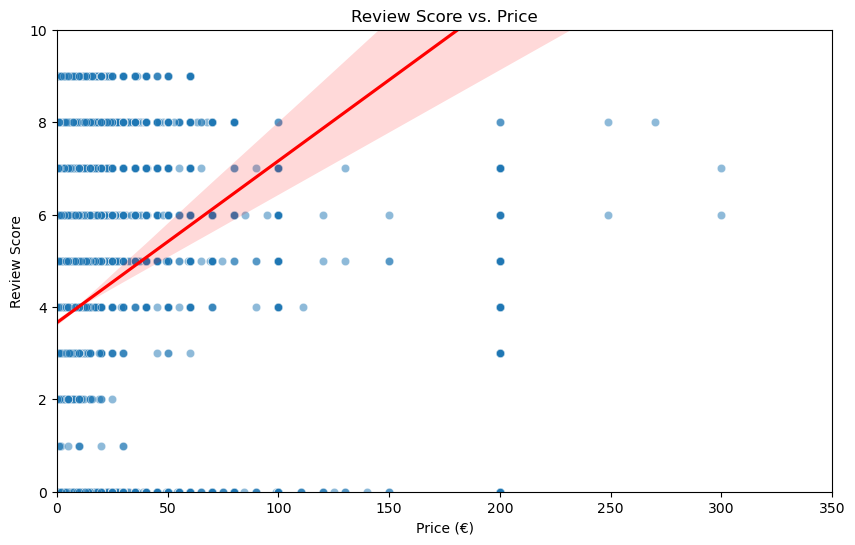

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='review_score', data=df_merged, alpha=0.5)
sns.regplot(x='price', y='review_score', data=df_merged, scatter=False, color='red')
plt.xlabel("Price (€)")
plt.ylabel("Review Score")
plt.title("Review Score vs. Price")
plt.ylim(0, 10)
plt.xlim(0, 350)
plt.show()

# Check if there’s a trend between a game’s price (in euros) and its review score

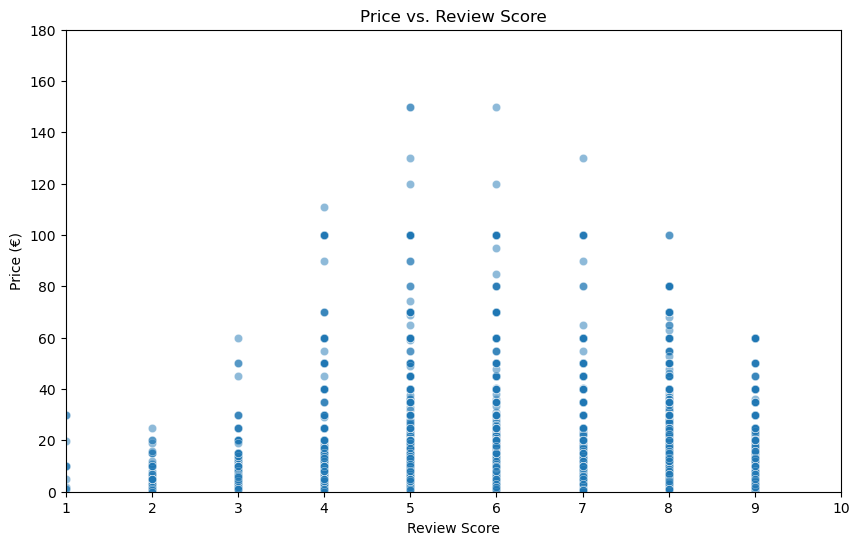

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_score', y='price', data=df_merged, alpha=0.5)
plt.xlabel("Review Score")
plt.ylabel("Price (€)")
plt.title("Price vs. Review Score")
plt.xlim(1, 10)
plt.ylim(0, 180)
plt.show()


['Indie',
 'Action',
 'Casual',
 'Adventure',
 'Simulation',
 'Strategy',
 'RPG',
 'Early Access',
 'Free To Play',
 'Sports']

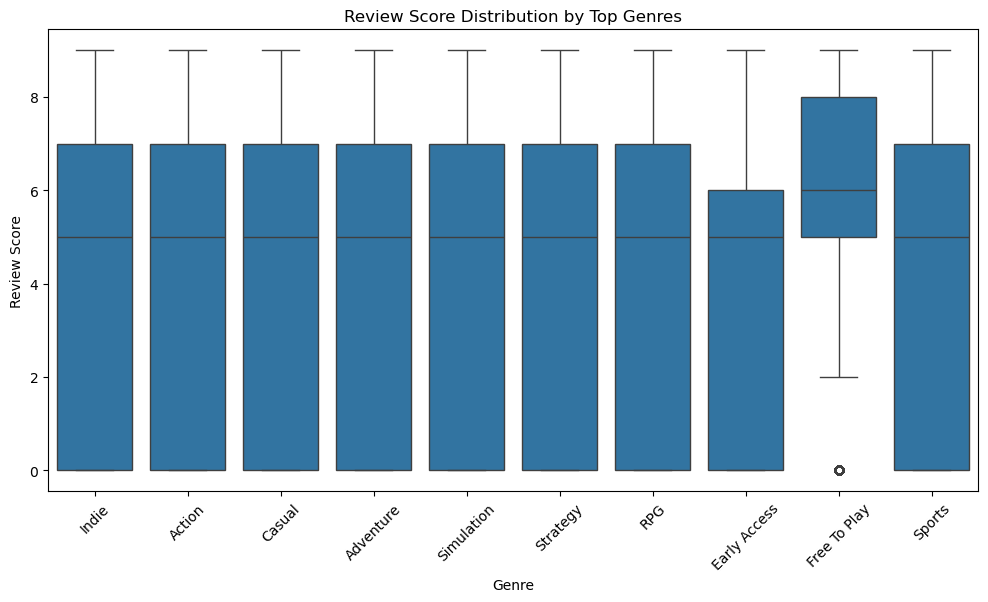

In [16]:
# Merge genre encoding with the main dataframe
df_merged = pd.concat([df_merged, genres_df_encoded], axis=1)

# For the top 10 most common genres
top_genres = df_merged[mlb_genre.classes_].sum().sort_values(ascending=False).head(10).index.tolist()
display(top_genres)
# Create a melted DataFrame for these genres
genre_cols = top_genres
df_genres = df_merged[['review_score'] + genre_cols].copy()
df_genres = df_genres.melt(id_vars='review_score', value_vars=genre_cols, var_name='genre', value_name='present')
df_genres = df_genres[df_genres['present'] == 1]  # keep only games with that genre

plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='review_score', data=df_genres)
plt.xlabel("Genre")
plt.ylabel("Review Score")
plt.title("Review Score Distribution by Top Genres")
plt.xticks(rotation=45)
plt.show()


# Compare the distribution of review scores for top 10 genres

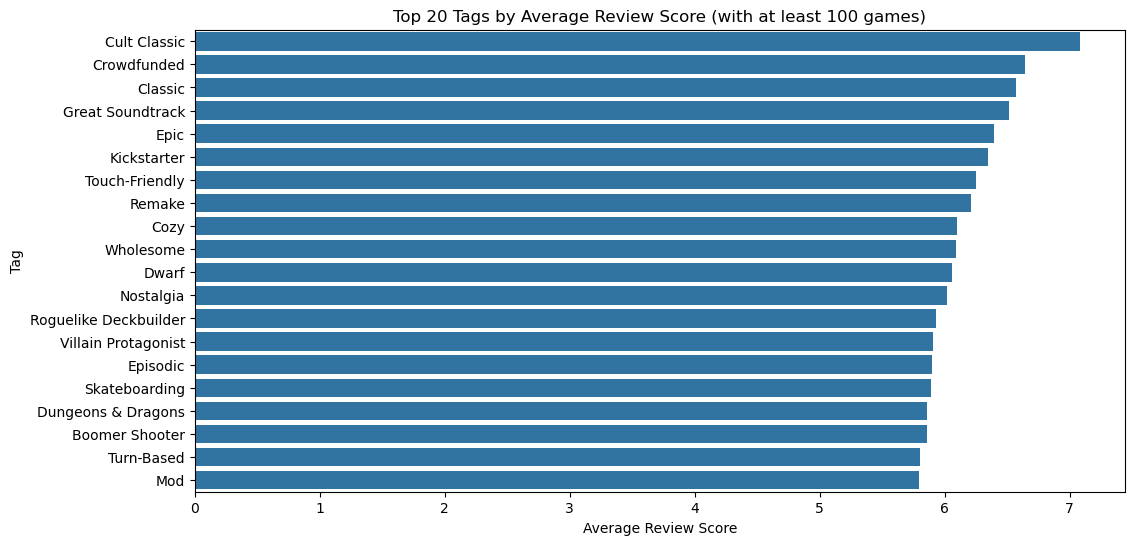

In [17]:
df_merged = pd.concat([df_merged, tags_df_encoded], axis=1)
df_merged2 = df_merged.copy()
df_merged2 = df_merged2.drop(columns=['tag'])

# Use the original tags_df (or re-read it) to create an exploded version
tags_exploded = tags_df.copy()
tags_exploded['tag'] = tags_exploded['tag'].str.split(', ')
tags_exploded = tags_exploded.explode('tag')

# Merge with the review scores from df_merged2 using app_id
tags_exploded = tags_exploded.merge(df_merged2[['app_id', 'review_score']], on='app_id', how='left')

# Now calculate average review score per tag
tag_review = tags_exploded.groupby('tag')['review_score'].mean().reset_index()

# Get tag counts
tag_counts = tags_exploded['tag'].value_counts().reset_index()
tag_counts.columns = ['tag', 'count']

# Merge to have counts alongside average review scores
tag_review = tag_review.merge(tag_counts, on='tag')

# Filter for the top 20 tags with a minimum count threshold (e.g., >50)
filtered_tags = tag_review[tag_review['count'] > 100].sort_values(by='review_score', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='review_score', y='tag', data=filtered_tags)
plt.xlabel("Average Review Score")
plt.ylabel("Tag")
plt.title("Top 20 Tags by Average Review Score (with at least 100 games)")
plt.show()


# Identify which tags are associated with higher or lower average review scores.

In [18]:
# Ensure 'tag' column is a list before exploding
df_exploded = df_merged[['app_id', 'tag', 'review_score']].copy()

df_exploded['tag'] = df_exploded['tag'].str.split(', ')
df_exploded = df_exploded.explode('tag')

# Compute average review score per tag
tag_review_scores = df_exploded.groupby('tag')['review_score'].mean().reset_index()

# Find the tag with the highest review score
top_tag = tag_review_scores.sort_values(by='review_score', ascending=False).iloc[0]

# Print the most popular tag by review score
print(f"The most popular tag by review score is '{top_tag['tag']}' with an average review score of {top_tag['review_score']:.2f}.")


The most popular tag by review score is 'Cult Classic' with an average review score of 7.09.


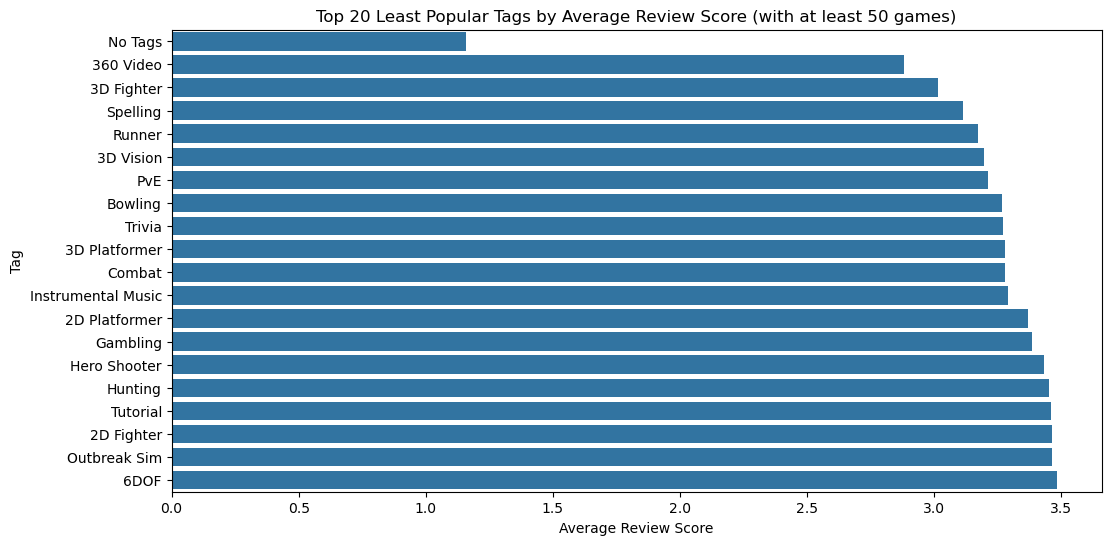

The least popular tag by review score is 'No Tags' with an average review score of 1.16.


In [19]:
# Create a separate DataFrame with only the relevant columns to avoid duplicate columns
df_exploded = df_merged[['app_id', 'tag', 'review_score']].copy()

# Convert the 'tag' column to a list and explode it
df_exploded['tag'] = df_exploded['tag'].str.split(', ')
df_exploded = df_exploded.explode('tag')

# Compute average review score per tag
tag_review_scores = df_exploded.groupby('tag')['review_score'].mean().reset_index()

# Sort in ascending order to get the least popular tags by review score
least_popular_tags = tag_review_scores.sort_values(by='review_score', ascending=True).head(20)

# Print a barplot for visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='review_score', y='tag', data=least_popular_tags)
plt.xlabel("Average Review Score")
plt.ylabel("Tag")
plt.title("Top 20 Least Popular Tags by Average Review Score (with at least 50 games)")
plt.show()

# Identify and print the absolute least popular tag
absolute_least_tag = least_popular_tags.iloc[0]
print(f"The least popular tag by review score is '{absolute_least_tag['tag']}' with an average review score of {absolute_least_tag['review_score']:.2f}.")


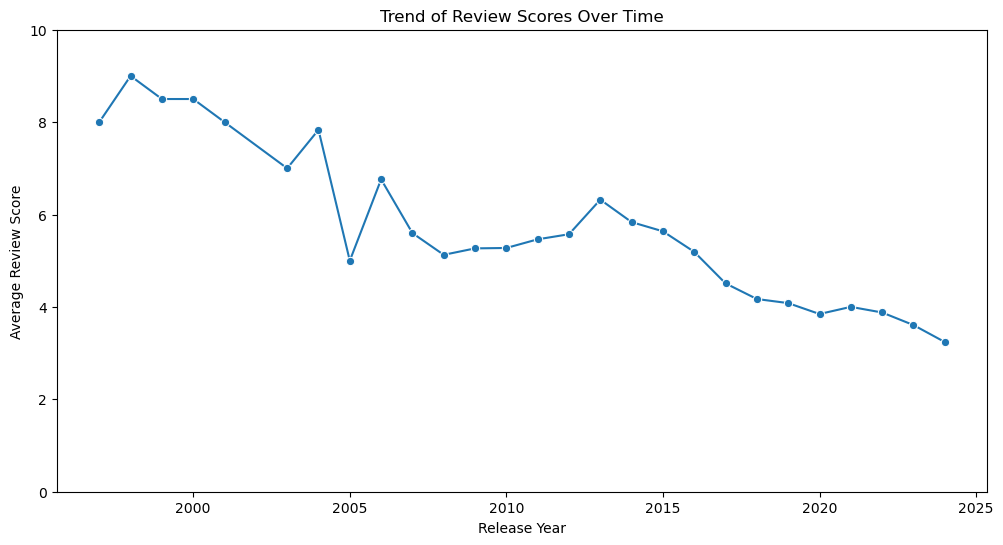

In [26]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='review_score', data=yearly_reviews, marker='o')
plt.xlabel("Release Year")
plt.ylabel("Average Review Score")
plt.title("Trend of Review Scores Over Time")
plt.ylim(0, 10)
plt.show()


# See how review scores have evolved over the years.


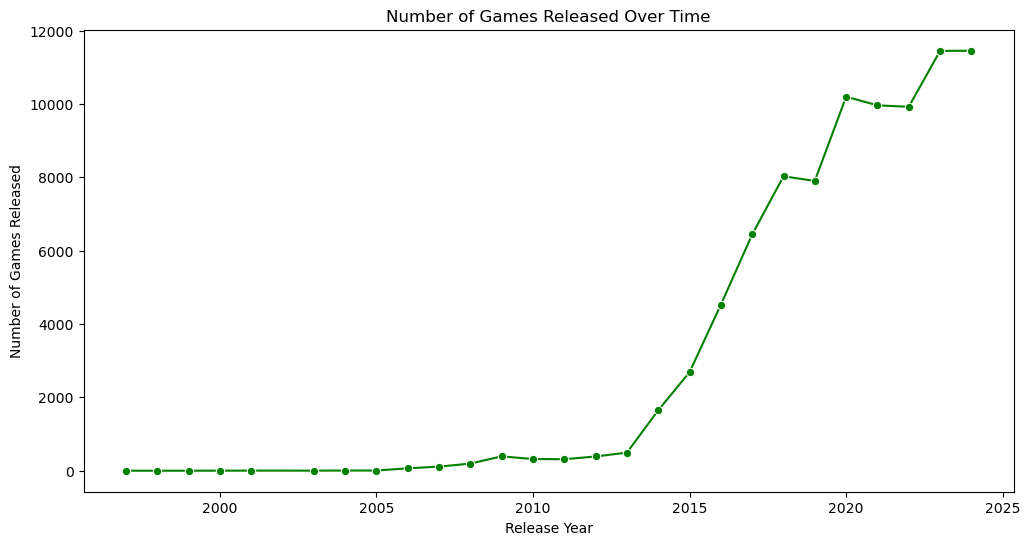

In [27]:
# Show the number of games released each year
# Maybe also show the number of games above and below the average review score for each year.
# Might work as a bar graph?

# x axis = year
# y axis = number of games
# stacked bar graph
# one stack is games with review score above average
# other stack is games with review score below average

# Count number of games released each year
yearly_game_counts = df_merged.groupby('release_year').size().reset_index(name='num_games')

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='num_games', data=yearly_game_counts, marker='o', color='green')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Released")
plt.title("Number of Games Released Over Time")
plt.show()





Average Review Score for all games: 4.07


<Figure size 1200x600 with 0 Axes>

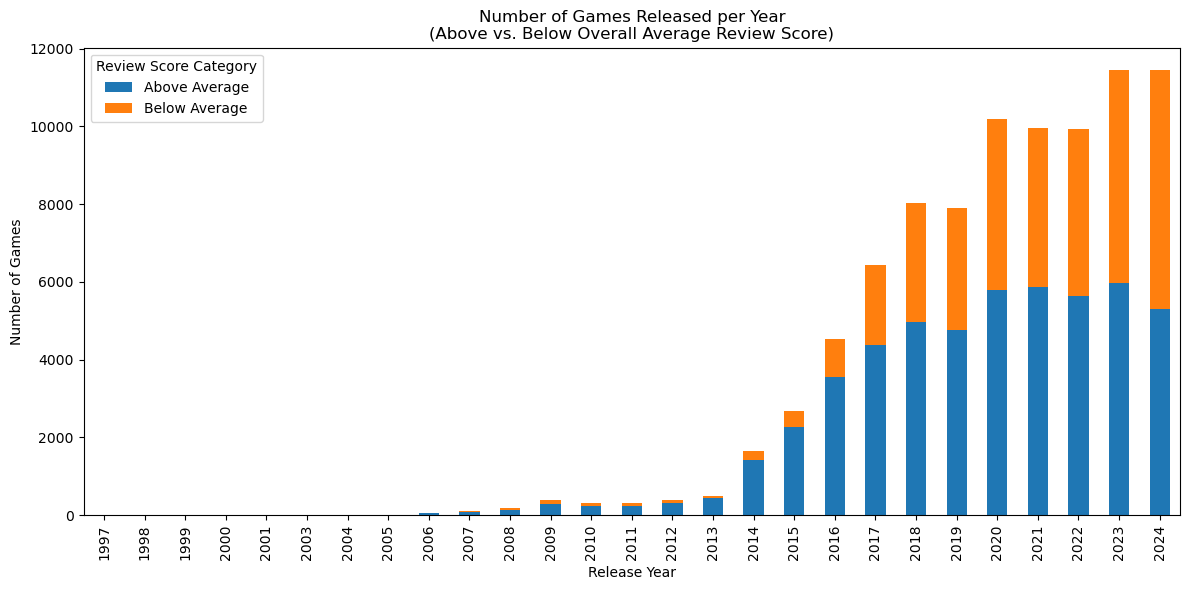

In [32]:
# Assume df_merged already has the 'review_score' and 'release_date' columns
# Convert release_date to datetime and drop invalid ones
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

# Calculate the overall average review score
avg_review = df_merged['review_score'].mean()
print(f"Average Review Score for all games: {avg_review:.2f}")

# Categorize games based on the average review score
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release_year and score_category and count the number of games
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot the table so that each year is a row and the categories are columns
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)

# Sort the index for a chronological order
yearly_pivot = yearly_pivot.sort_index()

# Plot a stacked bar graph
plt.figure(figsize=(12, 6))
yearly_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games Released per Year\n(Above vs. Below Overall Average Review Score)")
plt.legend(title="Review Score Category")
plt.tight_layout()
plt.show()


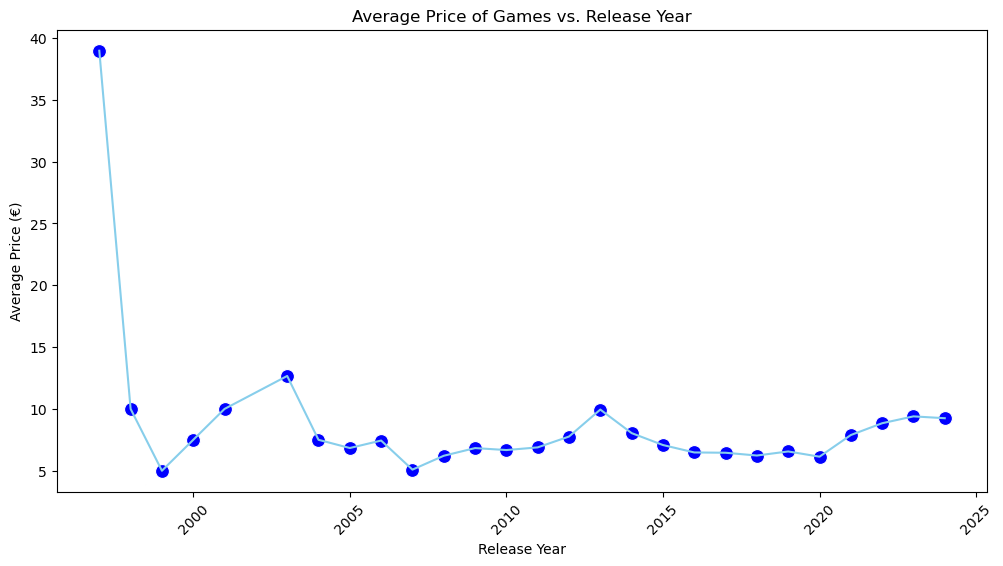

In [33]:
# Convert release_date to datetime, coercing errors and dropping NaT rows
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_year = df_merged.dropna(subset=['release_date']).copy()
df_year['release_year'] = df_year['release_date'].dt.year

# Group by release_year and compute average price per year
price_by_year = df_year.groupby('release_year')['price'].mean().reset_index()

# Plot the average price vs. release year
plt.figure(figsize=(12, 6))
sns.scatterplot(x='release_year', y='price', data=price_by_year, s=100, color='blue')
sns.lineplot(x='release_year', y='price', data=price_by_year, color='skyblue')
plt.xlabel("Release Year")
plt.ylabel("Average Price (€)")
plt.title("Average Price of Games vs. Release Year")
plt.xticks(rotation=45)
plt.show()


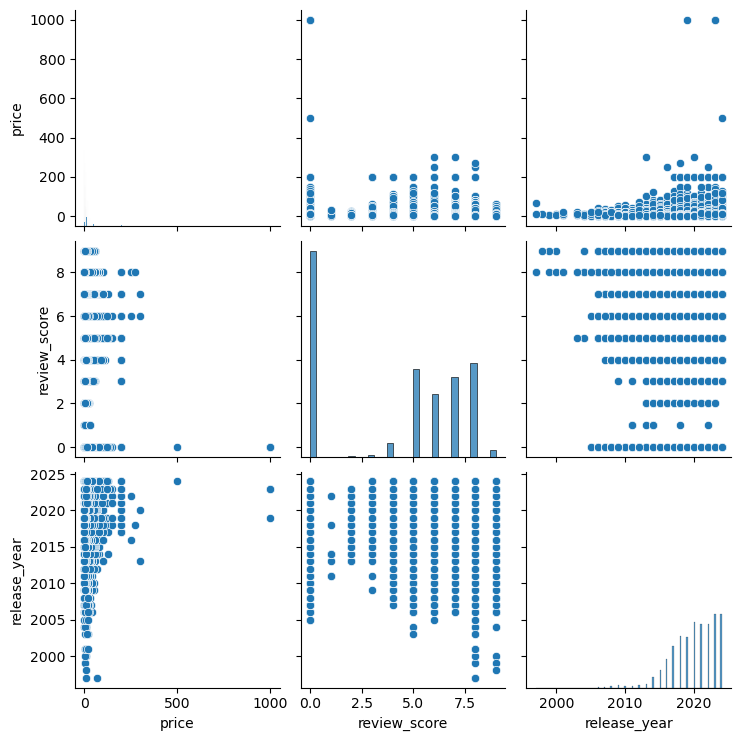

In [22]:
sns.pairplot(df_merged[['price', 'review_score', 'release_year']])
plt.show()


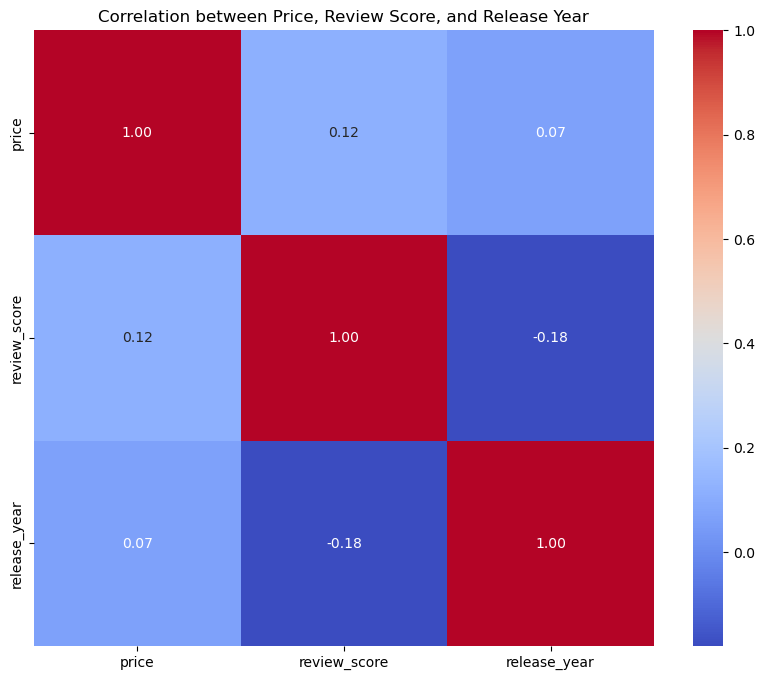

In [23]:
plt.figure(figsize=(10, 8))
corr = df_merged[['price', 'review_score', 'release_year']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Price, Review Score, and Release Year")
plt.show()


In [35]:
# Quality vs Quantity

# Overall average review score 
avg_review = df_merged['review_score'].mean()
print(f"Overall Average Review Score: {avg_review:.2f}")


Overall Average Review Score: 4.07


In [38]:
# Label each game
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release year and score category
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot for a stacked bar plot
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

display(yearly_pivot.head(30))



score_category,Above Average,Below Average
release_year,,
1997,2.0,0.0
1998,1.0,0.0
1999,2.0,0.0
2000,2.0,0.0
2001,4.0,0.0
2003,3.0,0.0
2004,6.0,0.0
2005,4.0,2.0
2006,61.0,6.0


Average Review Score for all games: 4.07


<Figure size 1200x600 with 0 Axes>

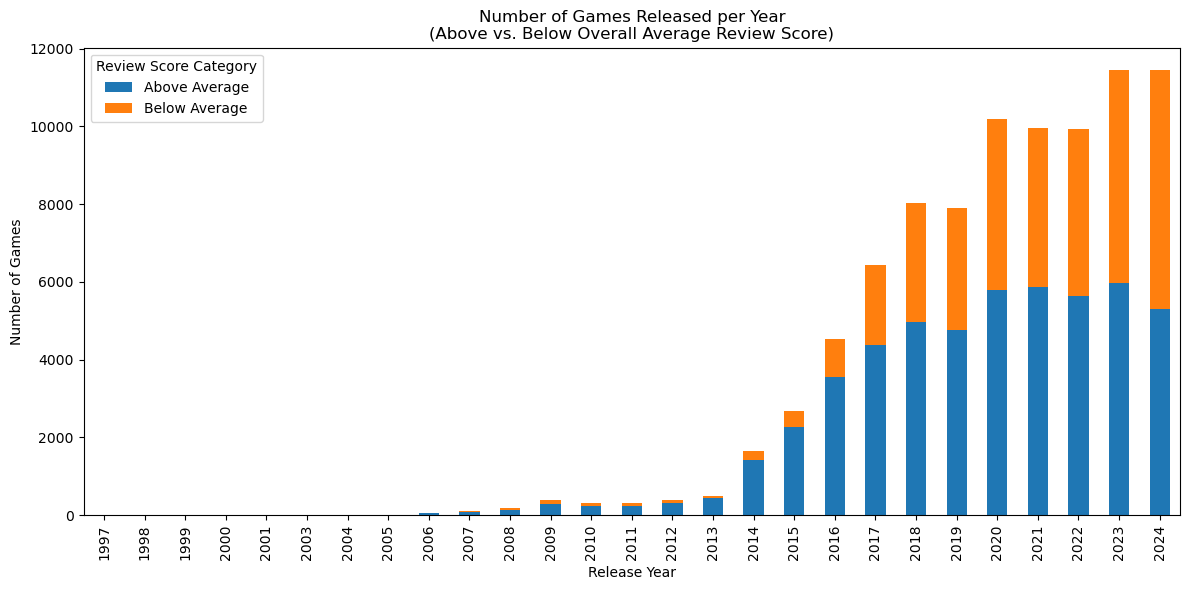

In [40]:
# Assume df_merged already has the 'review_score' and 'release_date' columns
# Convert release_date to datetime and drop invalid ones
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

# Calculate the overall average review score
avg_review = df_merged['review_score'].mean()
print(f"Average Review Score for all games: {avg_review:.2f}")

# Categorize games based on the average review score
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release_year and score_category and count the number of games
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot the table so that each year is a row and the categories are columns
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)

# Sort the index for a chronological order
yearly_pivot = yearly_pivot.sort_index()

# Plot a stacked bar graph
plt.figure(figsize=(12, 6))
yearly_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games Released per Year\n(Above vs. Below Overall Average Review Score)")
plt.legend(title="Review Score Category")
plt.tight_layout()
plt.show()

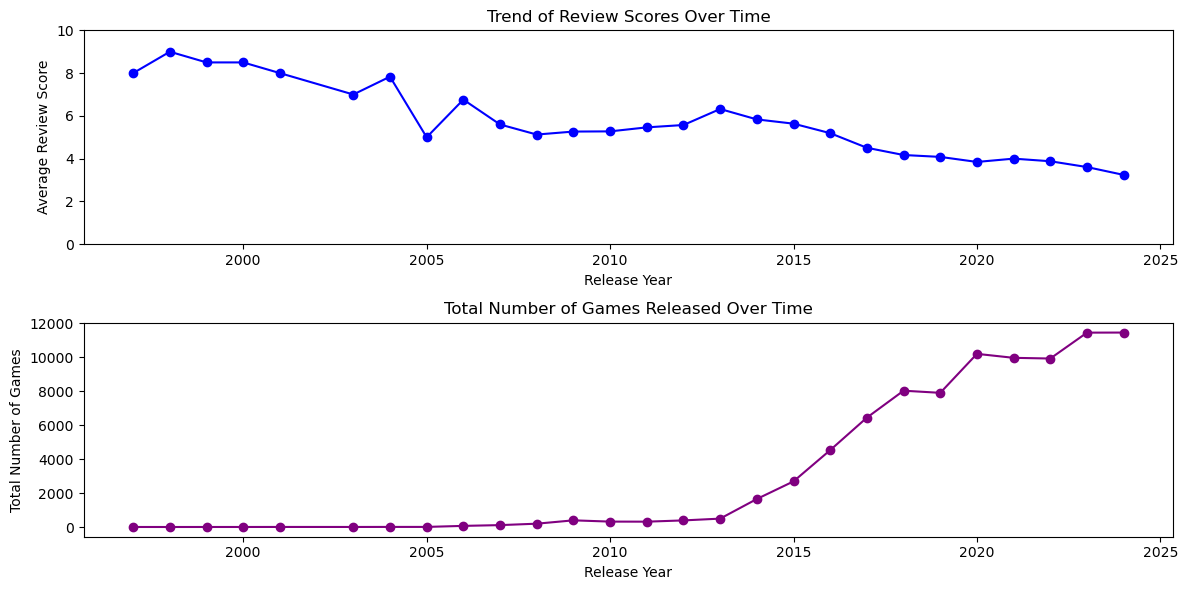

In [42]:
# Average review score per year
yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_reviews['release_year'], yearly_reviews['review_score'], marker='o', color='blue')
plt.xlabel("Release Year")
plt.ylabel("Average Review Score")
plt.title("Trend of Review Scores Over Time")
plt.ylim(0, 10)

# Total number of games per year
total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')
plt.subplot(2, 1, 2)
plt.plot(total_games['release_year'], total_games['total_games'], marker='o', color='purple')
plt.xlabel("Release Year")
plt.ylabel("Total Number of Games")
plt.title("Total Number of Games Released Over Time")
plt.tight_layout()
plt.show()

# Price vs. Review Trend:
# As you noted, recent years show a 50/50 split of games above and below the overall average review score.
# This may indicate market saturation with lower-quality games impacting the overall review average.

# Release Volume:
# The dramatic increase in the number of games (from fewer than 2000 to over 11,000 per year) 
# might be contributing to the drop in average review scores if many new games have lower ratings.


In [49]:

# Suppose you have a DataFrame 'total_games' with columns 'release_year' and 'total_games'
# For example, it could be created like this:
# total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')

# Prepare the feature and target arrays
X = total_games['release_year'].values.reshape(-1, 1)  # Independent variable: release year
y = total_games['total_games'].values                 # Dependent variable: total number of games

# Fit the linear regression model
lin_reg = LinearRegression().fit(X, y)
print("Coefficient:", lin_reg.coef_[0])
print("Intercept:", lin_reg.intercept_)

# Predict for future years, e.g., 2024 to 2028
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
predictions = lin_reg.predict(future_years)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'release_year': future_years.flatten(), 'predicted_total_games': predictions})
print(forecast_df)


Coefficient: 455.28565086881133
Intercept: -912291.0947025742
   release_year  predicted_total_games
0          2024            9207.062656
1          2025            9662.348307
2          2026           10117.633958
3          2027           10572.919609
4          2028           11028.205259


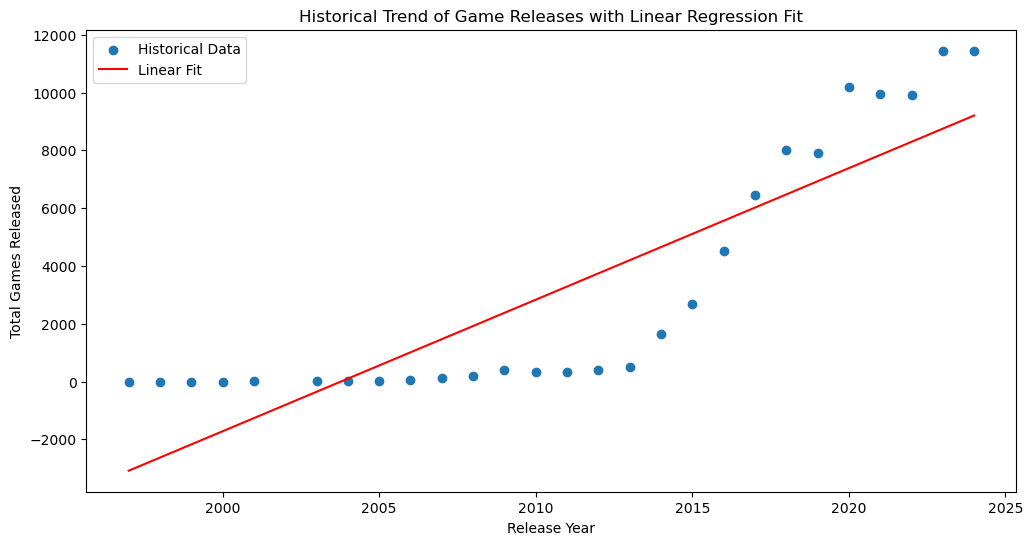

In [ ]:

plt.figure(figsize=(12,6))
plt.scatter(total_games['release_year'], total_games['total_games'], label='Historical Data')
plt.plot(total_games['release_year'], lin_reg.predict(X), color='red', label='Linear Fit')
plt.xlabel('Release Year')
plt.ylabel('Total Games Released')
plt.title('Historical Trend of Game Releases with Linear Regression Fit')
plt.legend()
plt.show()
